## Scketch an end to end pipeline to run classification models on new data and give predictions.
1. Get the light curve
    1. get light curve from DR2 set
        1. set parametes 
        1. form url using ZTF API format
        1. query URL
    1. get light curve from Xiao Dian's dataset
        1. set parameters
        1. form URL
        1. query URL
    1. plot flight curve per filter
1. Calculate features
    1. Take light curve
    1. calaculate all features
    1. return all features
1. Function run all the models with data
    1. Load all models
    1. pass feature data to all models and get prediction proba
    1. Return prediction proba for each classifier



In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle # allows to save differnt trained models of the same classifier object
import seaborn as sns
import time

In [2]:
def query_lightcurve_XD(SourceID): 
    """
    Download data for a single source from Xiao Dian's website. Source is identified using SourceID
    """
    url = 'http://variables.cn:88/seldataz.php?SourceID=' + str(SourceID)   
    try:
        lc_complete = pd.read_csv(url, header='infer')
        lc = lc_complete.drop(columns = ['SourceID','flag'])
    except:
        lc_complete = pd.DataFrame()
        lc = pd.DataFrame()
    return lc, lc_complete


In [3]:
def query_lightcurve_DR(RA, Dec): 
    """
    Download data for a single source from DR2 dataset. Source is identified using RA and Dec location
    """
    circle_radius = 0.0028 # 1 arcsec = 0.00028 degress
    t_format = "ipac_table"
    table_format = "FORMAT=" + str(t_format)
    flag_mask = 32768
    mask = "BAD_CATFLAGS_MASK=" + str(flag_mask)
    collect="COLLECTION="+"ztf_dr2"
    numobs = "NOBS_MIN=20"
#     filter_band = "g"
    label = []
    SourceID =[]
    start_time = time.time()
    ra = RA
    dec = Dec
    circle = "POS=CIRCLE"+"+"+str(ra)+"+"+str(dec)+"+"+str(circle_radius)
#     band = "BANDNAME="+ filter_band
    params = circle + "&" +  mask + "&" + numobs + "&" + collect + "&" + table_format

    try:
        url= "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?" + params
        lc_complete = pd.read_csv(url, header=None, delim_whitespace=True, skiprows=55) # extract data
        header = pd.read_csv(url, header=None, sep='|', skiprows=50,usecols=range(1,25), nrows=1)
        lc_complete.columns = header.iloc[0].str.strip()
        lc = lc_complete[['ra','dec','hjd','mag','magerr','filtercode']]
        lc.columns=['RAdeg', 'DEdeg', 'HJD', 'mag', 'e_mag', 'band']
        lc.replace({'zg':'g'},inplace = True)
        lc.replace({'zr':'r'},inplace = True)
#         lc.iloc['HJD',:] = lc.iloc['HJD',:]-2.4e6
    except:
        lc_complete = pd.DataFrame()
        lc = pd.DataFrame()
    print(url)
    return lc, lc_complete

In [4]:
def plot_lc(lc):
    """
    Function to plot the light curves
    """
    data1 = lc[lc['band']=='r']
    data2 = lc[lc['band']=='g']

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
    ax = axs[0]
    ax.errorbar(data1['HJD'],data1['mag'],yerr = data1['e_mag'],fmt='r.')
    ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
    ax.set_xlabel ('time in HJD')
    ax.set_ylabel('magnitude')
    ax.set_title('Red Filter')

    ax = axs[1]
    ax.errorbar(data2['HJD'],data2['mag'],yerr = data2['e_mag'],fmt='g.')
    ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
    ax.set_xlabel('time in HJD')
    ax.set_ylabel('magnitude')
    ax.set_title('Green filter')

    fig.tight_layout(pad=3.0)
    fig.suptitle('Measured Light Curve', fontsize=16)
    plt.show()

In [5]:
def weighted_mean(mag,mag_err):
    mag2 = (mag_err*mag_err) # mag err square
    mag2_inv = 1/mag2.values; # take inverse of the values
    w = pd.Series(mag2_inv) # covert it back to s series
    sw = w.sum() # sum of weights
    wmag = mag*w # multiply magnitude with weights
    wmean = wmag.sum()/sw # weighted mean
    return wmean

In [6]:
# welsh J, K statistics
def welsh_staton(mag_series,wmean):
    N = len(mag_series)
    d_i = N/(N-1)*(mag_series - wmean) # replace mean by weighted mean
    d_i1 = d_i.shift(periods=-1)
    d_i1.fillna(0, inplace = True)
    Pi = d_i*d_i1
    Pi_val = Pi.values
    Psign = np.sign(Pi_val)
    Jval = Psign*np.sqrt(np.abs(Pi_val))
    J = np.sum(Jval) 
    K1 = abs(d_i.values)/N
    K2 = np.sqrt(1/N*np.sum(d_i.values*d_i.values))
    K = np.sum(K1*K2)
    return J, K 

In [7]:
def calculate_features(lc):
    """
    Calculate features for a light curve passed as a dataframe.
    """
    g_mean = []
    g_wmean = [] # weighted mean
    g_MAD = []
    g_IQR = []
    g_f60 = []
    g_f70 = []
    g_f80 = []
    g_f90 = []
    g_skew = []
    g_kurtosis = []
    g_welsh_K = []
    g_welsh_J = []

    r_mean = []
    r_wmean = [] # weighted mean
    r_MAD = []
    r_IQR = []
    r_f60 = []
    r_f70 = []
    r_f80 = []
    r_f90 = []
    r_skew = []
    r_kurtosis = []
    r_welsh_K = []
    r_welsh_J = []
    
    if len(lc) >1:
        
        dfg = lc.loc[lc["band"] == "g"]
        dfr = lc.loc[lc["band"] == "r"]
        if len(dfg) > 1:
            N = len(dfg)
            wmean_temp = weighted_mean(dfg.mag,dfg.e_mag)
            K_temp, J_temp =  welsh_staton(dfg.mag, wmean_temp )
            g_mean.append(dfg.mag.mean())
            g_wmean.append(wmean_temp) 
            deviation = abs(dfg.mag - dfg.mag.median())
            g_MAD.append(deviation.median())
            g_IQR.append(dfg.mag.quantile(0.75) - dfg.mag.quantile(0.25))
            g_f60.append(dfg.mag.quantile(0.80) - dfg.mag.quantile(0.2))
            g_f70.append(dfg.mag.quantile(0.85) - dfg.mag.quantile(0.15))
            g_f80.append(dfg.mag.quantile(0.9) - dfg.mag.quantile(0.10))
            g_f90.append(dfg.mag.quantile(0.95) - dfg.mag.quantile(0.05))
            g_skew.append(dfg.mag.skew())
            g_kurtosis.append(dfg.mag.kurtosis())
            g_welsh_J.append(J_temp)
            g_welsh_K.append(K_temp)
        else:
            g_mean.append(np.NaN)
            g_wmean.append(np.NaN) 
            g_MAD.append(np.NaN)
            g_IQR.append(np.NaN)
            g_f60.append(np.NaN)
            g_f70.append(np.NaN)
            g_f80.append(np.NaN)
            g_f90.append(np.NaN)
            g_skew.append(np.NaN)
            g_kurtosis.append(np.NaN)
            g_welsh_J.append(np.NaN)
            g_welsh_K.append(np.NaN)
                
        if len(dfr) >1:
            N = len(dfr)
            wmean_temp = weighted_mean(dfr.mag,dfr.e_mag)
            K_temp, J_temp =  welsh_staton(dfr.mag, wmean_temp )
            r_mean.append(dfr.mag.mean())
            r_wmean.append(wmean_temp) 
            deviation = abs(dfr.mag - dfr.mag.median())
            r_MAD.append(deviation.median())
            r_IQR.append(dfr.mag.quantile(0.75) - dfr.mag.quantile(0.25))
            r_f60.append(dfr.mag.quantile(0.80) - dfr.mag.quantile(0.2))
            r_f70.append(dfr.mag.quantile(0.85) - dfr.mag.quantile(0.15))
            r_f80.append(dfr.mag.quantile(0.9) - dfr.mag.quantile(0.10))
            r_f90.append(dfr.mag.quantile(0.95) - dfr.mag.quantile(0.05))
            r_skew.append(dfr.mag.skew())
            r_kurtosis.append(dfr.mag.kurtosis())
            r_welsh_J.append(J_temp)
            r_welsh_K.append(K_temp)
        else:
            r_mean.append(np.NaN)
            r_wmean.append(np.NaN) 
            r_MAD.append(np.NaN)
            r_IQR.append(np.NaN)
            r_f60.append(np.NaN)
            r_f70.append(np.NaN)
            r_f80.append(np.NaN)
            r_f90.append(np.NaN)
            r_skew.append(np.NaN)
            r_kurtosis.append(np.NaN)
            r_welsh_J.append(np.NaN)
            r_welsh_K.append(np.NaN)

    else:
        g_mean.append(np.NaN)
        g_wmean.append(np.NaN) 
        g_MAD.append(np.NaN)
        g_IQR.append(np.NaN)
        g_f60.append(np.NaN)
        g_f70.append(np.NaN)
        g_f80.append(np.NaN)
        g_f90.append(np.NaN)
        g_skew.append(np.NaN)
        g_kurtosis.append(np.NaN)
        g_welsh_J.append(np.NaN)
        g_welsh_K.append(np.NaN)
        r_mean.append(np.NaN)
        r_wmean.append(np.NaN) 
        r_MAD.append(np.NaN)
        r_IQR.append(np.NaN) 
        r_f60.append(np.NaN)
        r_f70.append(np.NaN)
        r_f80.append(np.NaN)
        r_f90.append(np.NaN)
        r_skew.append(np.NaN)
        r_kurtosis.append(np.NaN)
        r_welsh_J.append(np.NaN)
        r_welsh_K.append(np.NaN)
        
    # del features
    features = pd.DataFrame()
    N = 1

    # g filter data
    features['g_mean'] = g_mean[0:N]
    features['g_wmean'] = g_wmean[0:N]
    features['g_MAD'] = g_MAD[0:N]
    features['g_IQR'] = g_IQR[0:N]
    features['g_f60'] = g_f60[0:N]
    features['g_f70'] = g_f70[0:N]
    features['g_f80'] = g_f80[0:N]
    features['g_f90'] = g_f90[0:N]
    features['g_skew'] = g_skew[0:N]
    features['g_kurtosis'] = g_kurtosis[0:N]
    features['g_welsh_J'] = g_welsh_J[0:N]
    features['g_welsh_K'] = g_welsh_K[0:N]

    # r filter data
    features['r_mean'] = r_mean[0:N]
    features['r_wmean'] = r_wmean[0:N]
    features['r_MAD'] = r_MAD[0:N]
    features['r_IQR'] = r_IQR[0:N]
    features['r_f60'] = r_f60[0:N]
    features['r_f70'] = r_f70[0:N]
    features['r_f80'] = r_f80[0:N]
    features['r_f90'] = r_f90[0:N]
    features['r_skew'] = r_skew[0:N]
    features['r_kurtosis'] = r_kurtosis[0:N]
    features['r_welsh_J'] = r_welsh_J[0:N]
    features['r_welsh_K'] = r_welsh_K[0:N]

    return features


In [8]:
def prediction_probabilty(features):
    """
    Predict probability for each of the 9 variable types using pre calculated features.
    """
    prob={}
    label = ['BYDra', 'EW', 'SR', 'RSCVN', 'RR', 'DSCT', 'EA', 'Mira', 'RRc']
    prob_pd = pd.DataFrame(columns=['Probability'],index=label)
    if np.isnan(features.iloc[0,:].values).all():
        pass
    else:
        for variable_type in label:
            print(variable_type)
            name = 'XGBoost'
            filename = '../pickles/'+ name+'_'+variable_type+'.pkl'
            clf = pickle.load(open(filename, 'rb'))
            predict_proba = clf.predict_proba(features)
            prob[variable_type] = round(predict_proba[0,0],2)
    #         prob[variable_type] = clf.predict_proba(features)
        prob_pd['Probability']=prob.values()
    return prob_pd
            

## Run whole pipeline

In [9]:
# query data
SourceID = 1
lc1,lc_complete1 =  query_lightcurve_XD(SourceID)
RA = 0.0
Dec = 62.1
lc2,lc_complete2 =  query_lightcurve_DR(RA, Dec)

https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE+0.0+62.1+0.0028&BAD_CATFLAGS_MASK=32768&NOBS_MIN=20&COLLECTION=ztf_dr2&FORMAT=ipac_table


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [10]:
# calculate features
features = calculate_features(lc2)

In [11]:
# run prediction models
prob = prediction_probabilty(features)
prob.head()

BYDra
EW
SR
RSCVN
RR
DSCT
EA
Mira
RRc


,Probability
BYDra,0.00
EW,0.19
SR,0.00
RSCVN,0.00
RR,0.00


In [12]:
features.head()

,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,g_f80,g_f90,g_skew,g_kurtosis,...,r_MAD,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K
0,18.945547,0.0,0.099257,2.315149,2.383024,2.436672,2.492247,2.552729,0.394918,-1.831794,...,0.059701,2.729128,2.75633,2.818816,4.012326,4.17381,0.686389,-1.228846,147.636945,5167.020938


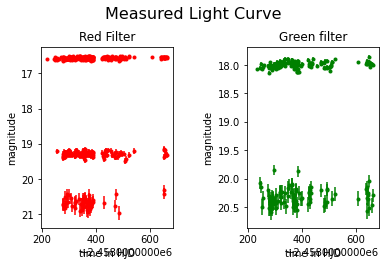

In [13]:
plot_lc(lc2)

In [14]:
lc2.head()

,RAdeg,DEdeg,HJD,mag,e_mag,band
0,0.000574,62.101603,2.458277e+06,16.536820,0.018923,r
1,0.000549,62.101618,2.458278e+06,16.628546,0.019470,r
2,0.000579,62.101616,2.458279e+06,16.558617,0.019049,r
3,0.000589,62.101623,2.458280e+06,16.641895,0.019554,r
4,0.000584,62.101613,2.458281e+06,16.562176,0.019070,r


In [15]:
val = lc2.loc[:,'HJD']-2.4e6
lc2.loc[:,'HJD'] = val

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [16]:
lc2.head()

,RAdeg,DEdeg,HJD,mag,e_mag,band
0,0.000574,62.101603,58276.964737,16.536820,0.018923,r
1,0.000549,62.101618,58277.927817,16.628546,0.019470,r
2,0.000579,62.101616,58278.970355,16.558617,0.019049,r
3,0.000589,62.101623,58279.926491,16.641895,0.019554,r
4,0.000584,62.101613,58280.969726,16.562176,0.019070,r


In [39]:
RA = np.round(lc2.RAdeg[0],3)
Dec = np.round(lc2.DEdeg[0],3)
ra_dec_str = "RA {} Dec {}".format(RA,Dec)

In [40]:
print(ra_dec_str)

RA 0.001 Dec 62.102
